In [1]:
from refine_histos_tools import *
from pathlib import Path
import os
from ROOT import TFile, TMath, TF1, gROOT, TCanvas, TGraph, TGraphErrors, TH1F
import numpy as np
from scipy.interpolate import PchipInterpolator

Welcome to JupyROOT 6.26/06


In [2]:
folder_out=os.path.join(
    os.path.dirname(os.getcwd()),
    "04_ML_classification"
)
path_root = Path(folder_out)
files=[root_file.as_posix() for root_file in path_root.glob('**/*.root')]
files

['/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_750/b_tau_tau_hadronic/Logistic_Regression.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_750/b_tau_tau_hadronic/Gradient_Boosting.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_1500/b_tau_tau_hadronic/Gradient_Boosting.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_500/b_tau_tau_hadronic/Logistic_Regression.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_500/b_tau_tau_hadronic/Gradient_Boosting.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_250/b_tau_tau_hadronic/Logistic_Regression.root',
 '/home/crisfer2694/Desktop/Pheno_BSM/Leptoquarks_searches/04_ML_classification/MLQ_250/b_tau_tau_hadronic/Gradient_Boosting.root']

z_jets_b_tau_tau_hadronic


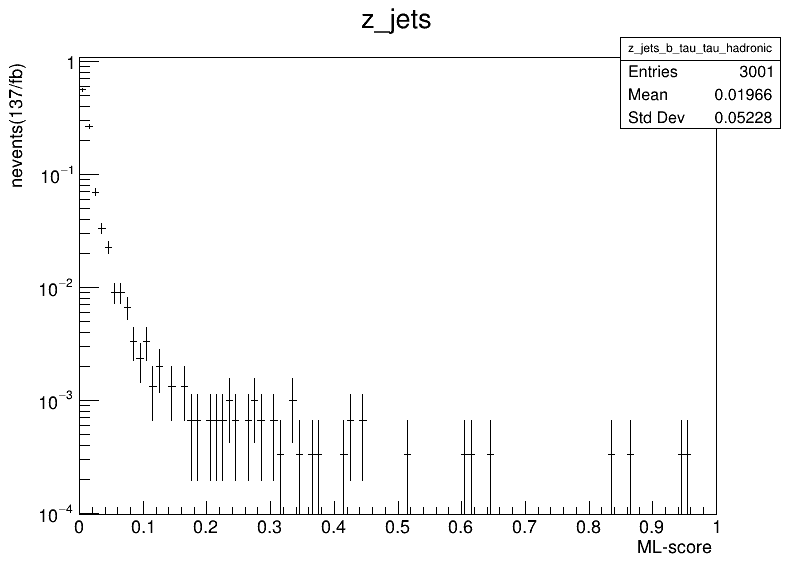

In [3]:
c1=TCanvas("","",800,600)
c1.SetLogy()
a=1
x=[0.]
y=[0.]
err_y=[0.]
for file in files:
    f=TFile(file)
    for h in getall(f):
        if not ( "z" in h.GetName()): continue
        h.Scale(1.0/h.Integral())
        h.Draw()
        print(h.GetName())
        sum_=0.
        erry=0.0
        dx=1./h.GetNbinsX()
        for i in range (h.GetNbinsX()):
            if h.GetBinContent(i+1) !=0 :
                x.append((i+1)*(1./h.GetNbinsX()))
                sum_+=h.GetBinContent(i+1)
                erry+=h.GetBinError(i+1)
                y.append(sum_)
                err_y.append(erry)
        break
    break
if x[len(x)-1]<1 :
    err_y.append(err_y[len(x)-1])
    x.append(1.)
    y.append(1.)
    
err_x=[dx/2 for i in x]
c1.Draw()


In [4]:
x=np.array(x)
err_y=np.array(err_y)
y=np.array(y)
err_x=np.array(err_x)
y_sup=y+err_y
y_inf=y-err_y

y_sup=y_sup#/max(y_sup)
y_inf=y_inf#/max(y_inf)


interp_func_sup=PchipInterpolator(x, y_sup)
interp_func_inf=PchipInterpolator(x, y_inf)

In [5]:
interp_func = PchipInterpolator(x, y)
new_x = np.arange(0.0, 1.00+5e-7, 5e-7)
new_y_sup = interp_func_sup(new_x)
new_y_inf = interp_func_inf(new_x)

X=new_x
Y=[np.random.normal((b+a)/2, (b-a)/8+1e-8) for a,b in zip(new_y_inf,new_y_sup)]

X=np.array(X)
Y=np.array(Y)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


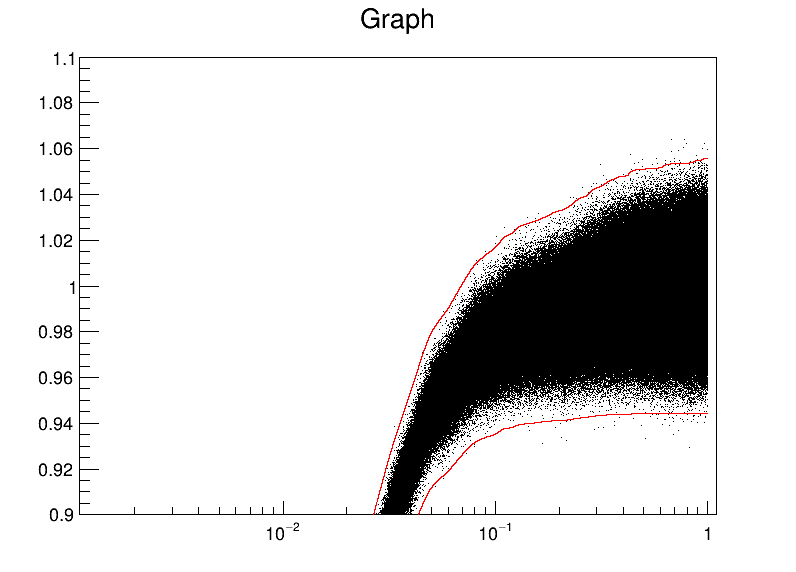

In [6]:
c1=TCanvas("c1","",800,600)
c1.SetLogx()
p="[0]*x"
#f1=TF1("f1",f"-4+log({p}/(1-{p}))",0.0001,0.9999)
#f1.SetParameter(0,1)
#f1.SetParameter(1,1)
g=TGraph(len(X),X,Y)#,err_x,err_y)
g.SetMinimum(9e-1)
g.SetMaximum(1.1)
g.SetMarkerStyle(1)
#g.Fit("f1")
#f1.SetParameter(0,1)
g2=TGraph(len(new_x),new_x,new_y_sup)
g2.SetLineColor(2)
g3=TGraph(len(new_x),new_x,new_y_inf)
g3.SetLineColor(2)
g.Draw("ap")
g2.Draw("l")
g3.Draw("l")
c1.Draw()

In [7]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=100, 
    max_depth=3, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
    monotone_constraints="(1)",
    nthread=4
)


In [8]:
xgb_x=X
xgb_y=Y
model.fit(np.vstack(xgb_x), xgb_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='(1)', n_estimators=100,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, ...)

In [9]:
from scipy.interpolate import splev, splrep
yhat = model.predict(xgb_x)
yhat = np.array([float(a) for a in yhat])
yhat = yhat/max(yhat)
spl = interpolate.splrep(X, yhat, s=1e-3)
ynew = splev(X, spl)

interp_func = PchipInterpolator(X, ynew)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


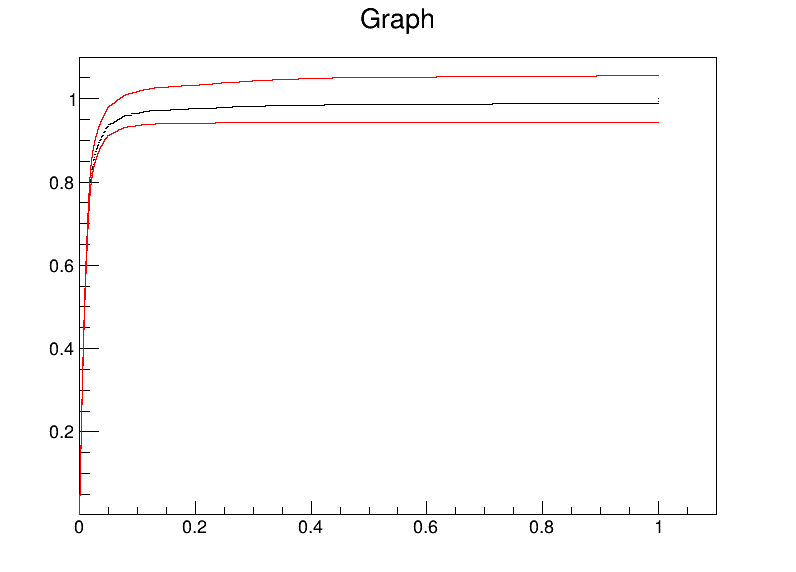

In [10]:
c1=TCanvas("c1","",800,600)
#c1.SetLogy()
#c1.SetLogx()
p="[0]*x"

g=TGraph(len(xgb_x),xgb_x,yhat)
#g.SetMinimum(6e-1)
#g.SetMaximum(1.1)
#g.GetXaxis().SetLimits(1e-3,1e-2)
g.SetMarkerStyle(1)
g2=TGraph(len(new_x),new_x,new_y_sup)
g2.SetLineColor(2)
g3=TGraph(len(new_x),new_x,new_y_inf)
g3.SetLineColor(2)
g.Draw("ap")
g2.Draw("l")
g3.Draw("l")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


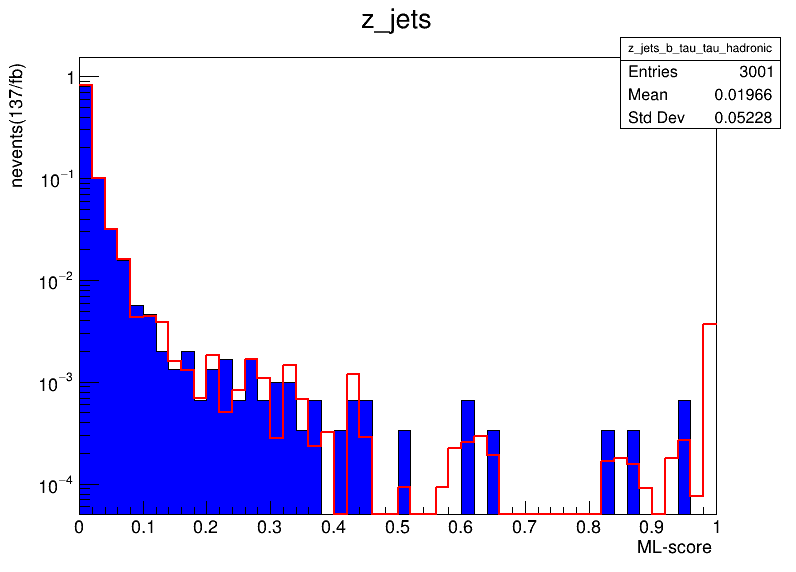

In [11]:
c1=TCanvas("c1","",800,600)
c1.SetLogy()
n_bins=50
hist_test=TH1F("test","test",n_bins,0.,1.)

for bin_ in range(hist_test.GetNbinsX()):
    hist_test.SetBinContent(bin_+1,interp_func((bin_+1)/n_bins)-interp_func((bin_)/n_bins))
    
h.Scale(1./h.Integral())
h.Draw("HIST")
h.Rebin(int(h.GetNbinsX()/n_bins))
h.SetMinimum(5e-5)

hist_test.Scale(1/hist_test.Integral())

hist_test.SetLineColor(2)
hist_test.SetLineWidth(2)
hist_test.DrawNormalized("HISTsame")

c1.Draw()